In [1]:
from torch.utils.data import Dataset,DataLoader
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
from functools import partial
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import optim
from tqdm import tqdm
import numpy as np
from refinement_module import UNet
from torch.optim.lr_scheduler import OneCycleLR
import random
from Datasets import WeihToI3
from model import UNet

/home/sow/venv/prism-uda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = WeihToI3(mode="val")

In [3]:
a = ds[1][0].float().unsqueeze(0)

In [4]:
a.shape

torch.Size([1, 1, 1024, 1024])

In [5]:
ds[1][1].shape

torch.Size([1, 1024, 1024])

In [6]:
model = UNet(2,2)

In [7]:
model(a,a).shape

> /home/sow/Documents/domain_adaptation/PRISM-UDA/model.py(439)forward()
    437         u0 = self.up0(d5,d4)
    438         pdb.set_trace()
--> 439         u1 = self.up1(u0, d3)
    440         u2 = self.up2(u1, d2)
    441         u3 = self.up3(u2, d1)

torch.Size([1, 128, 64, 64])


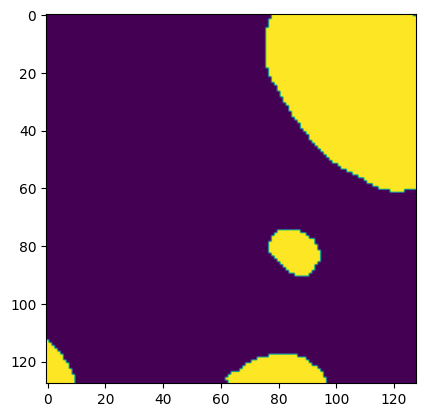

In [ ]:
plt.imshow(a.squeeze())

In [ ]:
def compute_iou(preds:torch.Tensor,gt:torch.Tensor,num_classes=2,ignore_index=255):
    mask = gt != ignore_index
    preds = preds[mask]
    gt = gt[mask]

    iou_list = []

    for cls in range(num_classes):
        cls_in_preds = preds == cls
        cls_in_gt = gt == cls

        intersection = (cls_in_preds & cls_in_gt).sum().item()
        union = (cls_in_preds | cls_in_gt).sum().item()

        if union == 0:
            iou_list.append(0)
            continue  # this class is not present in gt

        iou = intersection / union
        iou_list.append(iou)

    if not iou_list:
        raise ValueError("No class found in this predictions")
    return sum(iou_list) / len(iou_list)

def plot(pl:torch.Tensor,
         sam:torch.Tensor,
         preds:torch.Tensor,
         gt:torch.Tensor,
         epoch,
         batch_id,
         model_name,
         dataset_type,mask_type
         ):
    if batch_id % 200==0:
        pl = pl.squeeze().detach().cpu().numpy()
        sam = sam.squeeze().detach().cpu().numpy()
        preds = preds.squeeze().detach().cpu().numpy()
        gt = gt.squeeze().detach().cpu().numpy()

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

        axes[0].imshow(pl)
        axes[0].set_title("Pseudo label de l'EMA")

        axes[1].imshow(sam)
        axes[1].set_title("SAM")

        axes[2].imshow(preds)
        axes[2].set_title("Prédictions du raffineur")

        axes[3].imshow(gt)
        axes[3].set_title("Ground truth")

        plt.tight_layout()

        os.makedirs(f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/debug", exist_ok=True)
        plt.savefig(f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/debug/{epoch}_{batch_id}.png")
        plt.close(fig)

def save_metrics(train_losses,val_losses,train_m_iou,val_m_iou,model_name,dataset_type,mask_type):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_m_iou, label="Train mIoU")
    plt.plot(val_m_iou, label="Val mIoU")
    plt.legend()
    plt.title("Mean IoU")
    plt.savefig(f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/metrics.png")
    plt.close()


def one_batch(model,model_name,epoch,device,
              batch,batch_id,
              optimizer:optim.Optimizer,
              loss_function:nn.CrossEntropyLoss,
              dataset_type:str,mask_type,
              on_training=True):
    model.train() if on_training else model.eval()
    if dataset_type == "i3":
        pl,sam,gt = batch
        pl,sam,gt = pl.float(),sam.float(),gt.long()
        pl,sam,gt = pl.to(device),sam.to(device),gt.to(device)
        preds = model(pl,sam)
    else :
        sam,gt = batch
        sam,gt = sam.float(),gt.long()
        sam,gt = sam.to(device),gt.to(device)
        preds = model(sam,sam) 
    loss = loss_function(preds,gt.squeeze(1))
    if on_training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    preds = preds.argmax(dim=1)

    iou = compute_iou(preds,gt.squeeze(1))

    if not on_training :
        if dataset_type == "i3":
            plot(pl,sam,preds,gt,epoch,batch_id,model_name,dataset_type,mask_type)
        else :
            plot(sam,sam,preds,gt,epoch,batch_id,model_name,dataset_type,mask_type)

    return loss.item(), iou


def one_epoch(model,model_name,epoch,device,
              dataloader: DataLoader,
              optimizer:optim.Optimizer,
              loss_function:nn.CrossEntropyLoss,
              dataset_type:str,mask_type,
              on_training=True):
    train_loss = 0
    m_iou = 0
    N = 0
    for batch_id,batch in enumerate(dataloader):
        loss,iou = one_batch(model=model,model_name=model_name,mask_type=mask_type,epoch=epoch,device=device,batch=batch,batch_id=batch_id,optimizer=optimizer,dataset_type=dataset_type, loss_function=loss_function,on_training=on_training)
        if batch_id % 100 == 0: 
            print("train_loss = ",loss," epoch = ",epoch," batch_id = ",batch_id)
        train_loss = train_loss + loss
        m_iou = m_iou + iou
        N += 1
    return train_loss / N, m_iou / N

def train(model,max_epochs,lr,train_dl,val_dl,model_name,dataset_type,mask_type):
    train_losses = []
    val_losses = []
    train_m_iou = []
    val_m_iou = []
    device = "cuda" #if torch.cuda.is_available() else "cpu"
    best_val_iou = 1000

    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(),lr=lr)
    weight = torch.tensor([1.,5.],device=device)  
    loss_function = nn.CrossEntropyLoss(ignore_index=255)
    progress_bar = tqdm(range(max_epochs))

    if dataset_type == "i3":
        train_dataset = "i3"
        val_dataset = "i3"
    else:
        train_dataset = "weih"
        val_dataset = "weih"
    for epoch in progress_bar:
        train_loss, train_iou = one_epoch(model=model,model_name=model_name,mask_type=mask_type,epoch=epoch,device=device,dataloader=train_dl,optimizer=optimizer,dataset_type=train_dataset,loss_function=loss_function,on_training=True)
        train_losses.append(train_loss)
        train_m_iou.append(train_iou)
        with torch.no_grad():
            val_loss, val_iou = one_epoch(model=model,model_name=model_name,mask_type=mask_type,epoch=epoch,device=device,dataloader=val_dl,optimizer=optimizer,dataset_type=val_dataset,loss_function=loss_function,on_training=False)
            val_losses.append(val_loss)
            val_m_iou.append(val_iou)
        progress_bar.set_postfix(dict(train_loss=train_loss,train_iou=train_iou,val_loss=val_loss,val_iou=val_iou))
        # save losses and IoU
        save_metrics(train_losses,val_losses,train_m_iou,val_m_iou,model_name,dataset_type,mask_type=mask_type)
        if val_iou < best_val_iou:
            best_val_iou = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': val_iou
            }, f"refinement_results/{model_name}_train_on_{dataset_type}_mask_type_{mask_type}/best_checkpoint.pth")

In [ ]:
train_ds = WeihToI3(mode="train",)
val_ds = WeihToI3(mode="val",)
train_dl = DataLoader(train_ds,2,True,num_workers=8)
val_dl = DataLoader(val_ds,1,False,num_workers=8)

In [ ]:
train_ds[1][0].unique()

tensor([0, 1], dtype=torch.uint8)

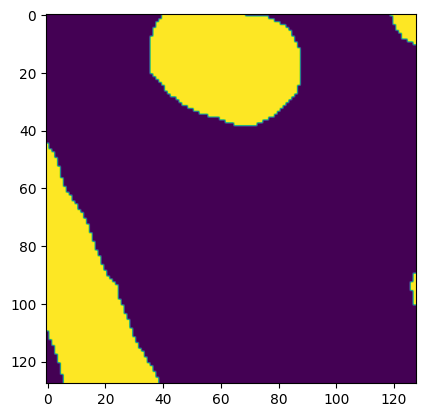

In [ ]:
plt.imshow(train_ds[0][2].squeeze())

In [ ]:
len(train_dl),len(val_dl)

(4182, 3585)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = UNet(2,2)

In [ ]:
train(model,50,1e-4,train_dl,val_dl,"Refine","i3","colour")

  0%|          | 0/50 [00:00<?, ?it/s]

train_loss =  0.6240667104721069  epoch =  0  batch_id =  0
train_loss =  0.4345565438270569  epoch =  0  batch_id =  100
train_loss =  0.22791819274425507  epoch =  0  batch_id =  200
train_loss =  0.4464794993400574  epoch =  0  batch_id =  300
train_loss =  0.2009187787771225  epoch =  0  batch_id =  400
train_loss =  0.25275811553001404  epoch =  0  batch_id =  500
train_loss =  0.827468752861023  epoch =  0  batch_id =  600
train_loss =  0.1712782084941864  epoch =  0  batch_id =  700
train_loss =  0.5238303542137146  epoch =  0  batch_id =  800
train_loss =  0.18170686066150665  epoch =  0  batch_id =  900
train_loss =  0.33149075508117676  epoch =  0  batch_id =  1000
train_loss =  0.27036720514297485  epoch =  0  batch_id =  1100
train_loss =  0.2485574632883072  epoch =  0  batch_id =  1200
train_loss =  0.28076639771461487  epoch =  0  batch_id =  1300
train_loss =  0.23736083507537842  epoch =  0  batch_id =  1400
train_loss =  0.27954888343811035  epoch =  0  batch_id =  15

  2%|▏         | 1/50 [15:03<12:18:06, 903.80s/it, train_loss=0.331, train_iou=0.447, val_loss=186, val_iou=0.448]

train_loss =  1.033709168434143  epoch =  1  batch_id =  0
